In [ ]:
# Install necessary libraries
!pip install wandb -q
!pip install gdown -q

In [ ]:
# Download and prepare the dataset
!gdown --id 1QXLgo3ZfQPorGwhYVmZUEWO_sU3i1pHM -O dataset.zip
!unzip -q dataset.zip -d .

# List the contents to verify
!ls dataset

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1QXLgo3ZfQPorGwhYVmZUEWO_sU3i1pHM
To: /content/dataset.zip
100% 57.8k/57.8k [00:00<00:00, 79.8MB/s]
training  validation


In [ ]:
import wandb

# Log in to your W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hibifovohig3 (hibifovohig3-add) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
%%writefile model.py
import torch
import torch.nn as nn
import torch.nn.functional as F # <-- IMPORTANT: This was missing in the original code

class DoubleConv(nn.Module):
    """(Convolution => [BatchNorm] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_colors, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_colors = n_colors
        self.bilinear = bilinear

        input_c = self.n_channels + self.n_colors

        self.inc = DoubleConv(input_c, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, img, color_vec):
        color_map = color_vec.unsqueeze(-1).unsqueeze(-1)
        color_map = color_map.expand(-1, -1, img.size(2), img.size(3))

        x = torch.cat([img, color_map], dim=1)

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return torch.sigmoid(logits)

Writing model.py


In [ ]:
%%writefile dataset.py
import json
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from torchvision import transforms

class PolygonDataset(Dataset):
    def __init__(self, data_dir, json_file, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        # Open and load the JSON file
        with open(os.path.join(data_dir, json_file), 'r') as f:
            self.data_map = json.load(f)

        self.samples = []
        for item in self.data_map:
            self.samples.append((item['input_polygon'], item['colour'], item['output_image']))

        all_colors = sorted(list(set([item['colour'] for item in self.data_map])))
        self.color_encoder = OneHotEncoder(sparse_output=False, categories=[all_colors])
        self.color_encoder.fit(np.array(all_colors).reshape(-1, 1))
        self.num_colors = len(all_colors)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_img_name, color_name, output_img_name = self.samples[idx]

        input_img_path = os.path.join(self.data_dir, 'inputs', input_img_name)
        output_img_path = os.path.join(self.data_dir, 'outputs', output_img_name)

        input_image = Image.open(input_img_path).convert("L")
        output_image = Image.open(output_img_path).convert("RGB")

        color_vec = self.color_encoder.transform(np.array(color_name).reshape(-1, 1)).flatten()
        color_vec = torch.tensor(color_vec, dtype=torch.float32)

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        return {
            'input_image': input_image,
            'color_vector': color_vec,
            'output_image': output_image
        }

def get_transforms(img_size):
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

Writing dataset.py


In [ ]:

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import wandb
from tqdm.notebook import tqdm
import os
import json
from PIL import Image
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import torch.nn.functional as F

# --- Helper Classes and Functions (Previously in dataset.py) ---
class PolygonDataset(Dataset):
    def __init__(self, data_dir, json_file, transform=None, color_encoder=None):
        self.data_dir = data_dir
        self.transform = transform

        with open(os.path.join(data_dir, json_file), 'r') as f:
            self.data_map = json.load(f)

        self.samples = []
        for item in self.data_map:
            self.samples.append((item['input_polygon'], item['colour'], item['output_image']))

        if color_encoder:
            self.color_encoder = color_encoder
        else:
            all_colors = sorted(list(set([item['colour'] for item in self.data_map])))
            self.color_encoder = OneHotEncoder(sparse_output=False, categories=[all_colors])
            self.color_encoder.fit(np.array(all_colors).reshape(-1, 1))

        self.num_colors = len(self.color_encoder.categories_[0])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_img_name, color_name, output_img_name = self.samples[idx]

        input_img_path = os.path.join(self.data_dir, 'inputs', input_img_name)
        output_img_path = os.path.join(self.data_dir, 'outputs', output_img_name)

        input_image = Image.open(input_img_path).convert("L")
        output_image = Image.open(output_img_path).convert("RGB")

        color_vec = self.color_encoder.transform(np.array(color_name).reshape(-1, 1)).flatten()
        color_vec = torch.tensor(color_vec, dtype=torch.float32)

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        return {
            'input_image': input_image,
            'color_vector': color_vec,
            'output_image': output_image
        }

def get_transforms(img_size):
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

# --- Import Model ---
from model import UNet

# --- Hyperparameters ---
config = {
    "learning_rate": 1e-3,
    "batch_size": 16,
    "epochs": 100,
    "image_size": 128
}

# --- Main Training Function ---
def train_model(config):
    run = wandb.init(project="ayna-ml-polygon-coloring", config=config, job_type="training")
    config = wandb.config

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img_transforms = get_transforms(config.image_size)

    train_dataset = PolygonDataset(data_dir='dataset/training', json_file='data.json', transform=img_transforms)
    val_dataset = PolygonDataset(data_dir='dataset/validation', json_file='data.json', transform=img_transforms, color_encoder=train_dataset.color_encoder)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

    model = UNet(n_channels=1, n_classes=3, n_colors=train_dataset.num_colors).to(device)

    criterion = torch.nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    wandb.watch(model, criterion, log="all", log_freq=100)
    best_val_loss = float('inf')

    for epoch in range(config.epochs):
        model.train()
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.epochs} [Training]")
        for batch in pbar:
            inputs = batch['input_image'].to(device)
            colors = batch['color_vector'].to(device)
            targets = batch['output_image'].to(device)

            outputs = model(inputs, colors)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'batch_loss': f'{loss.item():.4f}'})

        avg_train_loss = epoch_loss / len(train_loader)

        model.eval()
        val_loss = 0
        example_images = []
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{config.epochs} [Validation]")
        with torch.no_grad():
            for i, batch in enumerate(pbar_val):
                inputs = batch['input_image'].to(device)
                colors = batch['color_vector'].to(device)
                targets = batch['output_image'].to(device)

                outputs = model(inputs, colors)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                if i == 0:
                    for j in range(min(4, config.batch_size)):
                        # THE FIX IS APPLIED HERE: PAD ALL IMAGES SEPARATELY

                        # Prepare input: expand to 3 channels and pad
                        input_viz = F.pad(inputs[j].expand(3, -1, -1), (2, 2, 2, 2), "constant", 1.0)

                        # Prepare output: pad
                        output_viz = F.pad(outputs[j], (2, 2, 2, 2), "constant", 1.0)

                        # Prepare target: pad
                        target_viz = F.pad(targets[j], (2, 2, 2, 2), "constant", 1.0)

                        # Now all tensors are (3, 132, 132) and can be concatenated
                        img_strip = torch.cat([input_viz, output_viz, target_viz], dim=2)

                        example_images.append(wandb.Image(
                            img_strip,
                            caption=f"Input | Generated | Ground Truth"
                        ))

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1} -> Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "predictions": example_images
        })

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            os.makedirs('checkpoints', exist_ok=True)
            model_path = 'checkpoints/best_model.pth'
            torch.save(model.state_dict(), model_path)
            artifact = wandb.Artifact('polygon-model', type='model')
            artifact.add_file(model_path)
            run.log_artifact(artifact)
            print("✔️ Saved new best model to checkpoints/ and W&B.")

    wandb.finish()

# --- Start Training ---
train_model(config)

Epoch 1/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 -> Train Loss: 0.4587, Val Loss: 0.4868
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 2/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2 -> Train Loss: 0.3996, Val Loss: 0.8308


Epoch 3/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3 -> Train Loss: 0.3534, Val Loss: 0.9069


Epoch 4/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4 -> Train Loss: 0.3345, Val Loss: 0.8937


Epoch 5/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5 -> Train Loss: 0.3083, Val Loss: 0.8636


Epoch 6/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6 -> Train Loss: 0.2884, Val Loss: 0.6174


Epoch 7/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7 -> Train Loss: 0.2726, Val Loss: 0.5685


Epoch 8/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8 -> Train Loss: 0.2536, Val Loss: 0.4306
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 9/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9 -> Train Loss: 0.2392, Val Loss: 0.2440
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 10/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10 -> Train Loss: 0.2173, Val Loss: 0.2927


Epoch 11/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11 -> Train Loss: 0.2076, Val Loss: 0.1870
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 12/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12 -> Train Loss: 0.1870, Val Loss: 0.1586
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 13/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13 -> Train Loss: 0.1701, Val Loss: 0.1469
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 14/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14 -> Train Loss: 0.1608, Val Loss: 0.1339
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 15/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15 -> Train Loss: 0.1530, Val Loss: 0.1261
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 16/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16 -> Train Loss: 0.1475, Val Loss: 0.1536


Epoch 17/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17 -> Train Loss: 0.1285, Val Loss: 0.1446


Epoch 18/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18 -> Train Loss: 0.1225, Val Loss: 0.1555


Epoch 19/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19 -> Train Loss: 0.1092, Val Loss: 0.1299


Epoch 20/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20 -> Train Loss: 0.1055, Val Loss: 0.1038
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 21/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21 -> Train Loss: 0.0998, Val Loss: 0.1065


Epoch 22/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22 -> Train Loss: 0.0957, Val Loss: 0.0984
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 23/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23 -> Train Loss: 0.0861, Val Loss: 0.0910
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 24/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24 -> Train Loss: 0.0849, Val Loss: 0.0666
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 25/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25 -> Train Loss: 0.0803, Val Loss: 0.0635
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 26/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26 -> Train Loss: 0.0709, Val Loss: 0.0660


Epoch 27/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27 -> Train Loss: 0.0628, Val Loss: 0.0604
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 28/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28 -> Train Loss: 0.0582, Val Loss: 0.0515
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 29/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29 -> Train Loss: 0.0575, Val Loss: 0.0483
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 30/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30 -> Train Loss: 0.0479, Val Loss: 0.0481
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 31/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31 -> Train Loss: 0.0472, Val Loss: 0.0440
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 32/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32 -> Train Loss: 0.0530, Val Loss: 0.0369
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 33/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33 -> Train Loss: 0.0494, Val Loss: 0.0367
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 34/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34 -> Train Loss: 0.0453, Val Loss: 0.0361
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 35/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35 -> Train Loss: 0.0392, Val Loss: 0.0314
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 36/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36 -> Train Loss: 0.0388, Val Loss: 0.0264
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 37/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37 -> Train Loss: 0.0366, Val Loss: 0.0285


Epoch 38/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38 -> Train Loss: 0.0361, Val Loss: 0.0255
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 39/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39 -> Train Loss: 0.0348, Val Loss: 0.0275


Epoch 40/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40 -> Train Loss: 0.0314, Val Loss: 0.0275


Epoch 41/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41 -> Train Loss: 0.0322, Val Loss: 0.0291


Epoch 42/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42 -> Train Loss: 0.0289, Val Loss: 0.0228
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 43/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43 -> Train Loss: 0.0281, Val Loss: 0.0202
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 44/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44 -> Train Loss: 0.0281, Val Loss: 0.0193
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 45/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45 -> Train Loss: 0.0269, Val Loss: 0.0195


Epoch 46/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 46/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46 -> Train Loss: 0.0257, Val Loss: 0.0171
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 47/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47 -> Train Loss: 0.0231, Val Loss: 0.0165
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 48/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48 -> Train Loss: 0.0241, Val Loss: 0.0146
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 49/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49 -> Train Loss: 0.0221, Val Loss: 0.0147


Epoch 50/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50 -> Train Loss: 0.0200, Val Loss: 0.0167


Epoch 51/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 51/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51 -> Train Loss: 0.0210, Val Loss: 0.0166


Epoch 52/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 52/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52 -> Train Loss: 0.0189, Val Loss: 0.0161


Epoch 53/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 53/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53 -> Train Loss: 0.0200, Val Loss: 0.0162


Epoch 54/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 54/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54 -> Train Loss: 0.0185, Val Loss: 0.0141
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 55/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55 -> Train Loss: 0.0183, Val Loss: 0.0129
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 56/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 56/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56 -> Train Loss: 0.0183, Val Loss: 0.0125
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 57/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 57/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57 -> Train Loss: 0.0182, Val Loss: 0.0124
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 58/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 58/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58 -> Train Loss: 0.0169, Val Loss: 0.0119
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 59/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 59/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59 -> Train Loss: 0.0158, Val Loss: 0.0118
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 60/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60 -> Train Loss: 0.0152, Val Loss: 0.0119


Epoch 61/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 61/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61 -> Train Loss: 0.0162, Val Loss: 0.0107
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 62/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 62/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62 -> Train Loss: 0.0138, Val Loss: 0.0100
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 63/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 63/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63 -> Train Loss: 0.0141, Val Loss: 0.0109


Epoch 64/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 64/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64 -> Train Loss: 0.0154, Val Loss: 0.0101


Epoch 65/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65 -> Train Loss: 0.0153, Val Loss: 0.0196


Epoch 66/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 66/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66 -> Train Loss: 0.0137, Val Loss: 0.0112


Epoch 67/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 67/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67 -> Train Loss: 0.0135, Val Loss: 0.0087
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 68/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 68/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68 -> Train Loss: 0.0126, Val Loss: 0.0086
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 69/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 69/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69 -> Train Loss: 0.0162, Val Loss: 0.0097


Epoch 70/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70 -> Train Loss: 0.0156, Val Loss: 0.0108


Epoch 71/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 71/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71 -> Train Loss: 0.0131, Val Loss: 0.0101


Epoch 72/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 72/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72 -> Train Loss: 0.0132, Val Loss: 0.0091


Epoch 73/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 73/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73 -> Train Loss: 0.0121, Val Loss: 0.0080
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 74/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 74/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74 -> Train Loss: 0.0146, Val Loss: 0.0082


Epoch 75/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 75/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75 -> Train Loss: 0.0223, Val Loss: 0.0126


Epoch 76/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 76/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76 -> Train Loss: 0.0178, Val Loss: 0.0128


Epoch 77/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 77/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77 -> Train Loss: 0.0189, Val Loss: 0.0127


Epoch 78/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 78/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78 -> Train Loss: 0.0141, Val Loss: 0.0095


Epoch 79/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 79/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79 -> Train Loss: 0.0161, Val Loss: 0.0077
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 80/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80 -> Train Loss: 0.0141, Val Loss: 0.0080


Epoch 81/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 81/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81 -> Train Loss: 0.0120, Val Loss: 0.0065
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 82/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 82/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82 -> Train Loss: 0.0142, Val Loss: 0.0069


Epoch 83/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 83/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83 -> Train Loss: 0.0128, Val Loss: 0.0081


Epoch 84/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 84/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84 -> Train Loss: 0.0100, Val Loss: 0.0074


Epoch 85/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 85/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85 -> Train Loss: 0.0125, Val Loss: 0.0154


Epoch 86/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 86/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86 -> Train Loss: 0.0109, Val Loss: 0.0073


Epoch 87/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 87/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87 -> Train Loss: 0.0101, Val Loss: 0.0065


Epoch 88/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 88/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88 -> Train Loss: 0.0096, Val Loss: 0.0070


Epoch 89/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 89/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89 -> Train Loss: 0.0091, Val Loss: 0.0066


Epoch 90/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90 -> Train Loss: 0.0095, Val Loss: 0.0061
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 91/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 91/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91 -> Train Loss: 0.0085, Val Loss: 0.0052
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 92/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 92/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92 -> Train Loss: 0.0086, Val Loss: 0.0050
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 93/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 93/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93 -> Train Loss: 0.0073, Val Loss: 0.0048
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 94/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 94/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94 -> Train Loss: 0.0082, Val Loss: 0.0045
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 95/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 95/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95 -> Train Loss: 0.0101, Val Loss: 0.0045
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 96/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 96/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96 -> Train Loss: 0.0065, Val Loss: 0.0046


Epoch 97/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 97/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97 -> Train Loss: 0.0087, Val Loss: 0.0049


Epoch 98/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 98/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98 -> Train Loss: 0.0098, Val Loss: 0.0051


Epoch 99/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 99/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99 -> Train Loss: 0.0091, Val Loss: 0.0049


Epoch 100/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100 -> Train Loss: 0.0102, Val Loss: 0.0043
✔️ Saved new best model to checkpoints/ and W&B.


#with lr-schedular


In [ ]:


import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import wandb
from tqdm.notebook import tqdm
import os
import json
from PIL import Image
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import torch.nn.functional as F

class PolygonDataset(Dataset):
    def __init__(self, data_dir, json_file, transform=None, color_encoder=None):
        self.data_dir = data_dir
        self.transform = transform

        with open(os.path.join(data_dir, json_file), 'r') as f:
            self.data_map = json.load(f)

        self.samples = []
        for item in self.data_map:
            self.samples.append((item['input_polygon'], item['colour'], item['output_image']))

        if color_encoder:
            self.color_encoder = color_encoder
        else:
            all_colors = sorted(list(set([item['colour'] for item in self.data_map])))
            self.color_encoder = OneHotEncoder(sparse_output=False, categories=[all_colors])
            self.color_encoder.fit(np.array(all_colors).reshape(-1, 1))

        self.num_colors = len(self.color_encoder.categories_[0])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_img_name, color_name, output_img_name = self.samples[idx]

        input_img_path = os.path.join(self.data_dir, 'inputs', input_img_name)
        output_img_path = os.path.join(self.data_dir, 'outputs', output_img_name)

        input_image = Image.open(input_img_path).convert("L")
        output_image = Image.open(output_img_path).convert("RGB")

        color_vec = self.color_encoder.transform(np.array(color_name).reshape(-1, 1)).flatten()
        color_vec = torch.tensor(color_vec, dtype=torch.float32)

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        return {
            'input_image': input_image,
            'color_vector': color_vec,
            'output_image': output_image
        }

def get_transforms(img_size):
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

# --- Import Model ---
from model import UNet

# --- Hyperparameters ---
config = {
    "learning_rate": .1e-2,
    "batch_size": 16,
    "epochs": 100,
    "image_size": 128,
    "lr_scheduler_T_max": 100,
    "lr_scheduler_eta_min": 1e-4
}

# --- Main Training Function ---
def train_model(config):
    run = wandb.init(project="ayna-ml-polygon-coloring", config=config, job_type="training")
    config = wandb.config

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img_transforms = get_transforms(config.image_size)

    train_dataset = PolygonDataset(data_dir='dataset/training', json_file='data.json', transform=img_transforms)
    val_dataset = PolygonDataset(data_dir='dataset/validation', json_file='data.json', transform=img_transforms, color_encoder=train_dataset.color_encoder)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

    model = UNet(n_channels=1, n_classes=3, n_colors=train_dataset.num_colors).to(device)

    criterion = torch.nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    # ++ SCHEDULER INITIALIZATION ++
    # Create a learning rate scheduler that adjusts the learning rate over epochs.
    # CosineAnnealingLR smoothly decreases the LR from its initial value to a minimum (eta_min)
    # over a period of T_max epochs.
    scheduler = CosineAnnealingLR(optimizer, T_max=config.lr_scheduler_T_max, eta_min=config.lr_scheduler_eta_min)
    print(f"✔️ Initialized CosineAnnealingLR scheduler with T_max={config.lr_scheduler_T_max} and eta_min={config.lr_scheduler_eta_min}")


    wandb.watch(model, criterion, log="all", log_freq=100)
    best_val_loss = float('inf')

    for epoch in range(config.epochs):
        model.train()
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.epochs} [Training]")
        for batch in pbar:
            inputs = batch['input_image'].to(device)
            colors = batch['color_vector'].to(device)
            targets = batch['output_image'].to(device)

            outputs = model(inputs, colors)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'batch_loss': f'{loss.item():.4f}'})

        avg_train_loss = epoch_loss / len(train_loader)

        model.eval()
        val_loss = 0
        example_images = []
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{config.epochs} [Validation]")
        with torch.no_grad():
            for i, batch in enumerate(pbar_val):
                inputs = batch['input_image'].to(device)
                colors = batch['color_vector'].to(device)
                targets = batch['output_image'].to(device)

                outputs = model(inputs, colors)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                if i == 0:
                    for j in range(min(4, config.batch_size)):
                        input_viz = F.pad(inputs[j].expand(3, -1, -1), (2, 2, 2, 2), "constant", 1.0)
                        output_viz = F.pad(outputs[j], (2, 2, 2, 2), "constant", 1.0)
                        target_viz = F.pad(targets[j], (2, 2, 2, 2), "constant", 1.0)
                        img_strip = torch.cat([input_viz, output_viz, target_viz], dim=2)
                        example_images.append(wandb.Image(
                            img_strip,
                            caption=f"Input | Generated | Ground Truth"
                        ))

        avg_val_loss = val_loss / len(val_loader)
        current_lr = optimizer.param_groups[0]['lr'] # Get current learning rate
        print(f"Epoch {epoch+1} -> Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {current_lr:.6f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "learning_rate": current_lr, # ++ LOG LEARNING RATE ++
            "predictions": example_images
        })

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            os.makedirs('checkpoints', exist_ok=True)
            model_path = 'checkpoints/best_model.pth'
            torch.save(model.state_dict(), model_path)
            artifact = wandb.Artifact('polygon-model', type='model')
            artifact.add_file(model_path)
            run.log_artifact(artifact)
            print("✔️ Saved new best model to checkpoints/ and W&B.")


        # The scheduler's step should be called after each epoch to update the learning rate.
        scheduler.step()


    wandb.finish()

# --- Start Training ---
train_model(config)

✔️ Initialized CosineAnnealingLR scheduler with T_max=100 and eta_min=0.0001


Epoch 1/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 -> Train Loss: 0.4385, Val Loss: 0.4956, LR: 0.001000
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 2/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2 -> Train Loss: 0.4007, Val Loss: 0.7530, LR: 0.001000


Epoch 3/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3 -> Train Loss: 0.3584, Val Loss: 0.5837, LR: 0.000999


Epoch 4/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4 -> Train Loss: 0.3372, Val Loss: 0.5570, LR: 0.000998


Epoch 5/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5 -> Train Loss: 0.3185, Val Loss: 0.4552, LR: 0.000996
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 6/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6 -> Train Loss: 0.3026, Val Loss: 0.3353, LR: 0.000994
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 7/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7 -> Train Loss: 0.2994, Val Loss: 0.3180, LR: 0.000992
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 8/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8 -> Train Loss: 0.2711, Val Loss: 0.2957, LR: 0.000989
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 9/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9 -> Train Loss: 0.2518, Val Loss: 0.2652, LR: 0.000986
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 10/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10 -> Train Loss: 0.2361, Val Loss: 0.2275, LR: 0.000982
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 11/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11 -> Train Loss: 0.2262, Val Loss: 0.1918, LR: 0.000978
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 12/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12 -> Train Loss: 0.2080, Val Loss: 0.1567, LR: 0.000973
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 13/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13 -> Train Loss: 0.1967, Val Loss: 0.1664, LR: 0.000968


Epoch 14/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14 -> Train Loss: 0.1835, Val Loss: 0.1678, LR: 0.000963


Epoch 15/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15 -> Train Loss: 0.1709, Val Loss: 0.2070, LR: 0.000957


Epoch 16/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16 -> Train Loss: 0.1560, Val Loss: 0.2016, LR: 0.000951


Epoch 17/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17 -> Train Loss: 0.1428, Val Loss: 0.2629, LR: 0.000944


Epoch 18/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18 -> Train Loss: 0.1355, Val Loss: 0.1479, LR: 0.000937
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 19/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19 -> Train Loss: 0.1285, Val Loss: 0.1157, LR: 0.000930
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 20/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20 -> Train Loss: 0.1143, Val Loss: 0.1017, LR: 0.000922
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 21/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21 -> Train Loss: 0.1136, Val Loss: 0.0956, LR: 0.000914
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 22/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22 -> Train Loss: 0.1120, Val Loss: 0.0910, LR: 0.000906
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 23/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23 -> Train Loss: 0.1045, Val Loss: 0.0974, LR: 0.000897


Epoch 24/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24 -> Train Loss: 0.0956, Val Loss: 0.1036, LR: 0.000888


Epoch 25/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25 -> Train Loss: 0.0919, Val Loss: 0.0881, LR: 0.000878
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 26/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26 -> Train Loss: 0.0874, Val Loss: 0.0789, LR: 0.000868
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 27/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27 -> Train Loss: 0.0792, Val Loss: 0.0813, LR: 0.000858


Epoch 28/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28 -> Train Loss: 0.0802, Val Loss: 0.0741, LR: 0.000848
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 29/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29 -> Train Loss: 0.0734, Val Loss: 0.0601, LR: 0.000837
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 30/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30 -> Train Loss: 0.0702, Val Loss: 0.0594, LR: 0.000826
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 31/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31 -> Train Loss: 0.0674, Val Loss: 0.0536, LR: 0.000815
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 32/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32 -> Train Loss: 0.0683, Val Loss: 0.0594, LR: 0.000803


Epoch 33/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33 -> Train Loss: 0.0658, Val Loss: 0.0879, LR: 0.000791


Epoch 34/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34 -> Train Loss: 0.0589, Val Loss: 0.0559, LR: 0.000779


Epoch 35/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35 -> Train Loss: 0.0558, Val Loss: 0.0448, LR: 0.000767
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 36/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36 -> Train Loss: 0.0567, Val Loss: 0.0654, LR: 0.000754


Epoch 37/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37 -> Train Loss: 0.0600, Val Loss: 0.0646, LR: 0.000742


Epoch 38/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38 -> Train Loss: 0.0541, Val Loss: 0.0537, LR: 0.000729


Epoch 39/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39 -> Train Loss: 0.0530, Val Loss: 0.0883, LR: 0.000716


Epoch 40/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40 -> Train Loss: 0.0514, Val Loss: 0.0673, LR: 0.000702


Epoch 41/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41 -> Train Loss: 0.0473, Val Loss: 0.0430, LR: 0.000689
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 42/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42 -> Train Loss: 0.0447, Val Loss: 0.0379, LR: 0.000676
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 43/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43 -> Train Loss: 0.0453, Val Loss: 0.0370, LR: 0.000662
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 44/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44 -> Train Loss: 0.0403, Val Loss: 0.0316, LR: 0.000648
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 45/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45 -> Train Loss: 0.0437, Val Loss: 0.0333, LR: 0.000634


Epoch 46/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 46/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46 -> Train Loss: 0.0429, Val Loss: 0.0292, LR: 0.000620
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 47/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47 -> Train Loss: 0.0393, Val Loss: 0.0342, LR: 0.000606


Epoch 48/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48 -> Train Loss: 0.0357, Val Loss: 0.0311, LR: 0.000592


Epoch 49/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49 -> Train Loss: 0.0387, Val Loss: 0.0282, LR: 0.000578
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 50/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50 -> Train Loss: 0.0340, Val Loss: 0.0254, LR: 0.000564
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 51/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 51/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51 -> Train Loss: 0.0306, Val Loss: 0.0284, LR: 0.000550


Epoch 52/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 52/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52 -> Train Loss: 0.0310, Val Loss: 0.0270, LR: 0.000536


Epoch 53/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 53/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53 -> Train Loss: 0.0334, Val Loss: 0.0206, LR: 0.000522
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 54/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 54/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54 -> Train Loss: 0.0286, Val Loss: 0.0202, LR: 0.000508
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 55/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55 -> Train Loss: 0.0312, Val Loss: 0.0205, LR: 0.000494


Epoch 56/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 56/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56 -> Train Loss: 0.0292, Val Loss: 0.0204, LR: 0.000480


Epoch 57/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 57/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57 -> Train Loss: 0.0262, Val Loss: 0.0197, LR: 0.000466
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 58/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 58/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58 -> Train Loss: 0.0283, Val Loss: 0.0201, LR: 0.000452


Epoch 59/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 59/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59 -> Train Loss: 0.0258, Val Loss: 0.0234, LR: 0.000438


Epoch 60/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60 -> Train Loss: 0.0282, Val Loss: 0.0168, LR: 0.000424
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 61/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 61/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61 -> Train Loss: 0.0310, Val Loss: 0.0154, LR: 0.000411
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 62/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 62/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62 -> Train Loss: 0.0270, Val Loss: 0.0211, LR: 0.000398


Epoch 63/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 63/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63 -> Train Loss: 0.0285, Val Loss: 0.0146, LR: 0.000384
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 64/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 64/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64 -> Train Loss: 0.0295, Val Loss: 0.0151, LR: 0.000371


Epoch 65/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65 -> Train Loss: 0.0242, Val Loss: 0.0189, LR: 0.000358


Epoch 66/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 66/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66 -> Train Loss: 0.0232, Val Loss: 0.0174, LR: 0.000346


Epoch 67/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 67/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67 -> Train Loss: 0.0249, Val Loss: 0.0174, LR: 0.000333


Epoch 68/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 68/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68 -> Train Loss: 0.0229, Val Loss: 0.0164, LR: 0.000321


Epoch 69/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 69/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69 -> Train Loss: 0.0241, Val Loss: 0.0155, LR: 0.000309


Epoch 70/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70 -> Train Loss: 0.0302, Val Loss: 0.0153, LR: 0.000297


Epoch 71/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 71/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71 -> Train Loss: 0.0235, Val Loss: 0.0140, LR: 0.000285
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 72/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 72/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72 -> Train Loss: 0.0240, Val Loss: 0.0146, LR: 0.000274


Epoch 73/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 73/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73 -> Train Loss: 0.0224, Val Loss: 0.0148, LR: 0.000263


Epoch 74/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 74/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74 -> Train Loss: 0.0193, Val Loss: 0.0144, LR: 0.000252


Epoch 75/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 75/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75 -> Train Loss: 0.0199, Val Loss: 0.0134, LR: 0.000242
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 76/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 76/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76 -> Train Loss: 0.0206, Val Loss: 0.0132, LR: 0.000232
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 77/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 77/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77 -> Train Loss: 0.0201, Val Loss: 0.0138, LR: 0.000222


Epoch 78/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 78/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78 -> Train Loss: 0.0190, Val Loss: 0.0137, LR: 0.000212


Epoch 79/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 79/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79 -> Train Loss: 0.0192, Val Loss: 0.0133, LR: 0.000203


Epoch 80/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80 -> Train Loss: 0.0200, Val Loss: 0.0129, LR: 0.000194
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 81/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 81/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81 -> Train Loss: 0.0180, Val Loss: 0.0128, LR: 0.000186
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 82/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 82/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82 -> Train Loss: 0.0186, Val Loss: 0.0127, LR: 0.000178
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 83/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 83/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83 -> Train Loss: 0.0199, Val Loss: 0.0127, LR: 0.000170


Epoch 84/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 84/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84 -> Train Loss: 0.0177, Val Loss: 0.0132, LR: 0.000163


Epoch 85/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 85/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85 -> Train Loss: 0.0192, Val Loss: 0.0132, LR: 0.000156


Epoch 86/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 86/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86 -> Train Loss: 0.0184, Val Loss: 0.0132, LR: 0.000149


Epoch 87/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 87/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87 -> Train Loss: 0.0178, Val Loss: 0.0130, LR: 0.000143


Epoch 88/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 88/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88 -> Train Loss: 0.0202, Val Loss: 0.0125, LR: 0.000137
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 89/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 89/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89 -> Train Loss: 0.0186, Val Loss: 0.0126, LR: 0.000132


Epoch 90/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90 -> Train Loss: 0.0171, Val Loss: 0.0126, LR: 0.000127


Epoch 91/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 91/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91 -> Train Loss: 0.0176, Val Loss: 0.0125, LR: 0.000122
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 92/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 92/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92 -> Train Loss: 0.0171, Val Loss: 0.0122, LR: 0.000118
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 93/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 93/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93 -> Train Loss: 0.0167, Val Loss: 0.0121, LR: 0.000114
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 94/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 94/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94 -> Train Loss: 0.0186, Val Loss: 0.0121, LR: 0.000111


Epoch 95/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 95/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95 -> Train Loss: 0.0187, Val Loss: 0.0126, LR: 0.000108


Epoch 96/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 96/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96 -> Train Loss: 0.0173, Val Loss: 0.0123, LR: 0.000106


Epoch 97/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 97/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97 -> Train Loss: 0.0163, Val Loss: 0.0122, LR: 0.000104


Epoch 98/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 98/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98 -> Train Loss: 0.0158, Val Loss: 0.0122, LR: 0.000102


Epoch 99/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 99/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99 -> Train Loss: 0.0177, Val Loss: 0.0120, LR: 0.000101
✔️ Saved new best model to checkpoints/ and W&B.


Epoch 100/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100 -> Train Loss: 0.0158, Val Loss: 0.0122, LR: 0.000100


#with augmentation

In [28]:
# ==============================================================================
# FINAL TRAINING SCRIPT with SYNCHRONIZED DATA AUGMENTATION
# ==============================================================================

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# ++ IMPORT FUNCTIONAL API FOR AUGMENTATION ++
import torchvision.transforms.functional as TF
import wandb
from tqdm.notebook import tqdm
import os
import json
from PIL import Image
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import torch.nn.functional as F

# --- Helper Classes and Functions ---

class PolygonDataset(Dataset):
    # MODIFIED: Removed transform, added image_size
    def __init__(self, data_dir, json_file, image_size=128, color_encoder=None, is_train=True):
        self.data_dir = data_dir
        self.image_size = image_size
        self.color_encoder = color_encoder
        self.is_train = is_train # Flag to apply augmentation only on training set

        with open(os.path.join(data_dir, json_file), 'r') as f:
            self.data_map = json.load(f)

        self.samples = []
        for item in self.data_map:
            self.samples.append((item['input_polygon'], item['colour'], item['output_image']))

        # Create encoder only if not provided
        if self.color_encoder is None:
            all_colors = sorted(list(set([item['colour'] for item in self.data_map])))
            self.color_encoder = OneHotEncoder(sparse_output=False, categories=[all_colors])
            self.color_encoder.fit(np.array(all_colors).reshape(-1, 1))

        self.num_colors = len(self.color_encoder.categories_[0])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_img_name, color_name, output_img_name = self.samples[idx]

        input_img_path = os.path.join(self.data_dir, 'inputs', input_img_name)
        output_img_path = os.path.join(self.data_dir, 'outputs', output_img_name)

        input_image = Image.open(input_img_path).convert("L")
        output_image = Image.open(output_img_path).convert("RGB")

        # ++ PAIRED AUGMENTATION LOGIC ++

        # 1. Resize images first
        resize = transforms.Resize((self.image_size, self.image_size))
        input_image = resize(input_image)
        output_image = resize(output_image)

        # 2. Apply augmentations only to the training set
        if self.is_train:
            # Get a single set of random parameters for a powerful affine transform
            # This includes rotation, translation, and scaling in one operation.
            affine_params = transforms.RandomAffine.get_params(
                degrees=(-45, 45),                # Rotation
                translate=(0.15, 0.15),           # Translation
                scale_ranges=(0.85, 1.15),        # Scaling (zoom)
                shears=None,                      # Shear
                img_size=[self.image_size, self.image_size]
            )
            # Apply the exact same transformation to both images
            input_image = TF.affine(input_image, *affine_params, interpolation=transforms.InterpolationMode.BILINEAR)
            output_image = TF.affine(output_image, *affine_params, interpolation=transforms.InterpolationMode.BILINEAR)

            # Apply a synchronized random horizontal flip
            if torch.rand(1) < 0.5:
                input_image = TF.hflip(input_image)
                output_image = TF.hflip(output_image)

        # 3. Convert both images to tensors (must be done after augmentations)
        input_image = TF.to_tensor(input_image)
        output_image = TF.to_tensor(output_image)

        # --- End of Augmentation Logic ---

        color_vec = self.color_encoder.transform(np.array(color_name).reshape(-1, 1)).flatten()
        color_vec = torch.tensor(color_vec, dtype=torch.float32)

        return {
            'input_image': input_image,
            'color_vector': color_vec,
            'output_image': output_image
        }

# --- Import Model ---
from model import UNet

# --- Hyperparameters ---
config = {
    "learning_rate": 1e-3, # Reset to 1e-3 as it's a solid default
    "batch_size": 16,
    "epochs": 100,
    "image_size": 128,
    "lr_scheduler_T_max": 100,
    "lr_scheduler_eta_min": 1e-6 # Lower min LR for longer fine-tuning
}

# --- Main Training Function ---
def train_model(config):
    # Name the run to reflect the augmentation
    run = wandb.init(project="ayna-ml-polygon-coloring", config=config, name="Final-With-Augmentation", job_type="training")
    config = wandb.config

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # MODIFIED: The old get_transforms function is no longer needed.
    # We pass the image_size directly to the dataset.
    train_dataset = PolygonDataset(data_dir='dataset/training', json_file='data.json', image_size=config.image_size, is_train=True)
    # The validation set has is_train=False, so it will only be resized, not augmented.
    val_dataset = PolygonDataset(data_dir='dataset/validation', json_file='data.json', image_size=config.image_size, color_encoder=train_dataset.color_encoder, is_train=False)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

    model = UNet(n_channels=1, n_classes=3, n_colors=train_dataset.num_colors).to(device)

    criterion = torch.nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    scheduler = CosineAnnealingLR(optimizer, T_max=config.lr_scheduler_T_max, eta_min=config.lr_scheduler_eta_min)
    print(f"✔️ Initialized CosineAnnealingLR scheduler with T_max={config.lr_scheduler_T_max} and eta_min={config.lr_scheduler_eta_min}")


    wandb.watch(model, criterion, log="all", log_freq=100)
    best_val_loss = float('inf')

    for epoch in range(config.epochs):
        model.train()
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.epochs} [Training]")
        for batch in pbar:
            inputs = batch['input_image'].to(device)
            colors = batch['color_vector'].to(device)
            targets = batch['output_image'].to(device)

            outputs = model(inputs, colors)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'batch_loss': f'{loss.item():.4f}'})

        avg_train_loss = epoch_loss / len(train_loader)

        model.eval()
        val_loss = 0
        example_images = []
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{config.epochs} [Validation]")
        with torch.no_grad():
            for i, batch in enumerate(pbar_val):
                inputs = batch['input_image'].to(device)
                colors = batch['color_vector'].to(device)
                targets = batch['output_image'].to(device)

                outputs = model(inputs, colors)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                if i == 0:
                    for j in range(min(4, config.batch_size)):
                        input_viz = F.pad(inputs[j].expand(3, -1, -1), (2, 2, 2, 2), "constant", 1.0)
                        output_viz = F.pad(outputs[j], (2, 2, 2, 2), "constant", 1.0)
                        target_viz = F.pad(targets[j], (2, 2, 2, 2), "constant", 1.0)
                        img_strip = torch.cat([input_viz, output_viz, target_viz], dim=2)
                        example_images.append(wandb.Image(
                            img_strip,
                            caption=f"Input | Generated | Ground Truth"
                        ))

        avg_val_loss = val_loss / len(val_loader)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1} -> Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {current_lr:.6f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "learning_rate": current_lr,
            "predictions": example_images
        })

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            os.makedirs('checkpoints', exist_ok=True)
            # Save the augmented model with a new name to avoid overwriting
            model_path = 'checkpoints/best_model_augmented.pth'
            torch.save(model.state_dict(), model_path)
            artifact = wandb.Artifact('polygon-model-augmented', type='model')
            artifact.add_file(model_path)
            run.log_artifact(artifact)
            print(f"✔️ Saved new best augmented model to {model_path} and W&B.")

        scheduler.step()

    wandb.finish()

# --- Start Training ---
train_model(config)

✔️ Initialized CosineAnnealingLR scheduler with T_max=100 and eta_min=1e-06


Epoch 1/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 -> Train Loss: 0.4233, Val Loss: 0.4826, LR: 0.001000
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 2/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2 -> Train Loss: 0.3515, Val Loss: 0.4792, LR: 0.001000
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 3/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3 -> Train Loss: 0.3229, Val Loss: 0.4785, LR: 0.000999
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 4/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4 -> Train Loss: 0.2977, Val Loss: 0.4753, LR: 0.000998
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 5/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5 -> Train Loss: 0.2925, Val Loss: 0.4752, LR: 0.000996
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 6/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6 -> Train Loss: 0.2676, Val Loss: 0.4478, LR: 0.000994
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 7/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7 -> Train Loss: 0.2651, Val Loss: 0.2965, LR: 0.000991
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 8/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8 -> Train Loss: 0.2350, Val Loss: 0.3120, LR: 0.000988


Epoch 9/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9 -> Train Loss: 0.2252, Val Loss: 0.3079, LR: 0.000984


Epoch 10/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10 -> Train Loss: 0.2137, Val Loss: 0.3759, LR: 0.000980


Epoch 11/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11 -> Train Loss: 0.1968, Val Loss: 0.3581, LR: 0.000976


Epoch 12/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12 -> Train Loss: 0.1839, Val Loss: 0.3397, LR: 0.000970


Epoch 13/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13 -> Train Loss: 0.1780, Val Loss: 0.3544, LR: 0.000965


Epoch 14/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14 -> Train Loss: 0.1596, Val Loss: 0.3550, LR: 0.000959


Epoch 15/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15 -> Train Loss: 0.1603, Val Loss: 0.3260, LR: 0.000952


Epoch 16/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16 -> Train Loss: 0.1483, Val Loss: 0.3491, LR: 0.000946


Epoch 17/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17 -> Train Loss: 0.1461, Val Loss: 0.3124, LR: 0.000938


Epoch 18/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18 -> Train Loss: 0.1358, Val Loss: 0.3592, LR: 0.000930


Epoch 19/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19 -> Train Loss: 0.1404, Val Loss: 0.3948, LR: 0.000922


Epoch 20/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20 -> Train Loss: 0.1253, Val Loss: 0.4018, LR: 0.000914


Epoch 21/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21 -> Train Loss: 0.1184, Val Loss: 0.3125, LR: 0.000905


Epoch 22/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22 -> Train Loss: 0.1066, Val Loss: 0.2467, LR: 0.000895
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 23/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23 -> Train Loss: 0.1089, Val Loss: 0.2365, LR: 0.000885
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 24/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24 -> Train Loss: 0.1132, Val Loss: 0.1955, LR: 0.000875
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 25/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25 -> Train Loss: 0.1005, Val Loss: 0.2115, LR: 0.000865


Epoch 26/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26 -> Train Loss: 0.1014, Val Loss: 0.2313, LR: 0.000854


Epoch 27/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27 -> Train Loss: 0.0997, Val Loss: 0.2359, LR: 0.000842


Epoch 28/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28 -> Train Loss: 0.0919, Val Loss: 0.2128, LR: 0.000831


Epoch 29/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29 -> Train Loss: 0.0981, Val Loss: 0.1914, LR: 0.000819
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 30/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30 -> Train Loss: 0.0914, Val Loss: 0.1250, LR: 0.000807
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 31/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31 -> Train Loss: 0.0848, Val Loss: 0.1638, LR: 0.000794


Epoch 32/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32 -> Train Loss: 0.0803, Val Loss: 0.1979, LR: 0.000781


Epoch 33/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33 -> Train Loss: 0.0869, Val Loss: 0.1497, LR: 0.000768


Epoch 34/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34 -> Train Loss: 0.0796, Val Loss: 0.1186, LR: 0.000755
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 35/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35 -> Train Loss: 0.0755, Val Loss: 0.1261, LR: 0.000741


Epoch 36/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36 -> Train Loss: 0.0696, Val Loss: 0.0767, LR: 0.000727
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 37/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37 -> Train Loss: 0.0678, Val Loss: 0.0636, LR: 0.000713
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 38/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38 -> Train Loss: 0.0576, Val Loss: 0.1317, LR: 0.000699


Epoch 39/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39 -> Train Loss: 0.0647, Val Loss: 0.1501, LR: 0.000684


Epoch 40/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40 -> Train Loss: 0.0510, Val Loss: 0.0534, LR: 0.000670
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 41/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41 -> Train Loss: 0.0447, Val Loss: 0.1619, LR: 0.000655


Epoch 42/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42 -> Train Loss: 0.0491, Val Loss: 0.1324, LR: 0.000640


Epoch 43/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43 -> Train Loss: 0.0503, Val Loss: 0.0506, LR: 0.000625
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 44/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44 -> Train Loss: 0.0592, Val Loss: 0.1371, LR: 0.000609


Epoch 45/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45 -> Train Loss: 0.0492, Val Loss: 0.2997, LR: 0.000594


Epoch 46/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 46/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46 -> Train Loss: 0.0449, Val Loss: 0.1710, LR: 0.000579


Epoch 47/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47 -> Train Loss: 0.0435, Val Loss: 0.1129, LR: 0.000563


Epoch 48/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48 -> Train Loss: 0.0510, Val Loss: 0.0623, LR: 0.000548


Epoch 49/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49 -> Train Loss: 0.0462, Val Loss: 0.0511, LR: 0.000532


Epoch 50/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50 -> Train Loss: 0.0366, Val Loss: 0.0586, LR: 0.000516


Epoch 51/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 51/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51 -> Train Loss: 0.0465, Val Loss: 0.0260, LR: 0.000501
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 52/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 52/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52 -> Train Loss: 0.0358, Val Loss: 0.0361, LR: 0.000485


Epoch 53/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 53/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53 -> Train Loss: 0.0324, Val Loss: 0.0318, LR: 0.000469


Epoch 54/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 54/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54 -> Train Loss: 0.0330, Val Loss: 0.0220, LR: 0.000453
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 55/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55 -> Train Loss: 0.0325, Val Loss: 0.0194, LR: 0.000438
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 56/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 56/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56 -> Train Loss: 0.0288, Val Loss: 0.0212, LR: 0.000422


Epoch 57/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 57/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57 -> Train Loss: 0.0297, Val Loss: 0.0229, LR: 0.000407


Epoch 58/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 58/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58 -> Train Loss: 0.0299, Val Loss: 0.0202, LR: 0.000392


Epoch 59/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 59/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59 -> Train Loss: 0.0280, Val Loss: 0.0200, LR: 0.000376


Epoch 60/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60 -> Train Loss: 0.0255, Val Loss: 0.0201, LR: 0.000361


Epoch 61/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 61/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61 -> Train Loss: 0.0245, Val Loss: 0.0206, LR: 0.000346


Epoch 62/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 62/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62 -> Train Loss: 0.0331, Val Loss: 0.0184, LR: 0.000331
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 63/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 63/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63 -> Train Loss: 0.0264, Val Loss: 0.0177, LR: 0.000317
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 64/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 64/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64 -> Train Loss: 0.0226, Val Loss: 0.0184, LR: 0.000302


Epoch 65/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65 -> Train Loss: 0.0267, Val Loss: 0.0199, LR: 0.000288


Epoch 66/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 66/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66 -> Train Loss: 0.0252, Val Loss: 0.0191, LR: 0.000274


Epoch 67/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 67/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67 -> Train Loss: 0.0275, Val Loss: 0.0179, LR: 0.000260


Epoch 68/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 68/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68 -> Train Loss: 0.0219, Val Loss: 0.0177, LR: 0.000246
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 69/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 69/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69 -> Train Loss: 0.0211, Val Loss: 0.0172, LR: 0.000233
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 70/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70 -> Train Loss: 0.0232, Val Loss: 0.0172, LR: 0.000220
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 71/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 71/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71 -> Train Loss: 0.0198, Val Loss: 0.0164, LR: 0.000207
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 72/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 72/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72 -> Train Loss: 0.0215, Val Loss: 0.0163, LR: 0.000194
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 73/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 73/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73 -> Train Loss: 0.0267, Val Loss: 0.0158, LR: 0.000182
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 74/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 74/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74 -> Train Loss: 0.0196, Val Loss: 0.0153, LR: 0.000170
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 75/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 75/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75 -> Train Loss: 0.0238, Val Loss: 0.0156, LR: 0.000159


Epoch 76/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 76/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76 -> Train Loss: 0.0209, Val Loss: 0.0150, LR: 0.000147
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 77/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 77/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77 -> Train Loss: 0.0195, Val Loss: 0.0148, LR: 0.000136
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 78/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 78/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78 -> Train Loss: 0.0223, Val Loss: 0.0149, LR: 0.000126


Epoch 79/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 79/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79 -> Train Loss: 0.0208, Val Loss: 0.0153, LR: 0.000116


Epoch 80/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80 -> Train Loss: 0.0203, Val Loss: 0.0159, LR: 0.000106


Epoch 81/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 81/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81 -> Train Loss: 0.0200, Val Loss: 0.0164, LR: 0.000096


Epoch 82/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 82/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82 -> Train Loss: 0.0188, Val Loss: 0.0163, LR: 0.000087


Epoch 83/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 83/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83 -> Train Loss: 0.0209, Val Loss: 0.0157, LR: 0.000079


Epoch 84/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 84/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84 -> Train Loss: 0.0207, Val Loss: 0.0152, LR: 0.000071


Epoch 85/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 85/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85 -> Train Loss: 0.0209, Val Loss: 0.0148, LR: 0.000063


Epoch 86/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 86/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86 -> Train Loss: 0.0186, Val Loss: 0.0150, LR: 0.000055


Epoch 87/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 87/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87 -> Train Loss: 0.0185, Val Loss: 0.0149, LR: 0.000049


Epoch 88/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 88/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88 -> Train Loss: 0.0175, Val Loss: 0.0146, LR: 0.000042
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 89/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 89/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89 -> Train Loss: 0.0173, Val Loss: 0.0143, LR: 0.000036
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 90/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90 -> Train Loss: 0.0169, Val Loss: 0.0140, LR: 0.000031
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 91/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 91/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91 -> Train Loss: 0.0216, Val Loss: 0.0143, LR: 0.000025


Epoch 92/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 92/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92 -> Train Loss: 0.0180, Val Loss: 0.0142, LR: 0.000021


Epoch 93/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 93/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93 -> Train Loss: 0.0179, Val Loss: 0.0139, LR: 0.000017
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 94/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 94/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94 -> Train Loss: 0.0188, Val Loss: 0.0139, LR: 0.000013
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 95/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 95/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95 -> Train Loss: 0.0165, Val Loss: 0.0135, LR: 0.000010
✔️ Saved new best augmented model to checkpoints/best_model_augmented.pth and W&B.


Epoch 96/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 96/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96 -> Train Loss: 0.0185, Val Loss: 0.0142, LR: 0.000007


Epoch 97/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 97/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97 -> Train Loss: 0.0184, Val Loss: 0.0146, LR: 0.000005


Epoch 98/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 98/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98 -> Train Loss: 0.0176, Val Loss: 0.0143, LR: 0.000003


Epoch 99/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 99/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99 -> Train Loss: 0.0182, Val Loss: 0.0142, LR: 0.000002


Epoch 100/100 [Training]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/100 [Validation]:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100 -> Train Loss: 0.0182, Val Loss: 0.0141, LR: 0.000001


#Choose your color and shape...
###choose the shape whose png file is present in the validation


✅ Recreated color encoder. Available colors: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']

✅ Model loaded successfully from '/content/checkpoints/best_model_augmented.pth' and set to evaluation mode.

▶️ Running inference for 'OIP (1).webp' with color 'blue'...
✅ Inference complete.


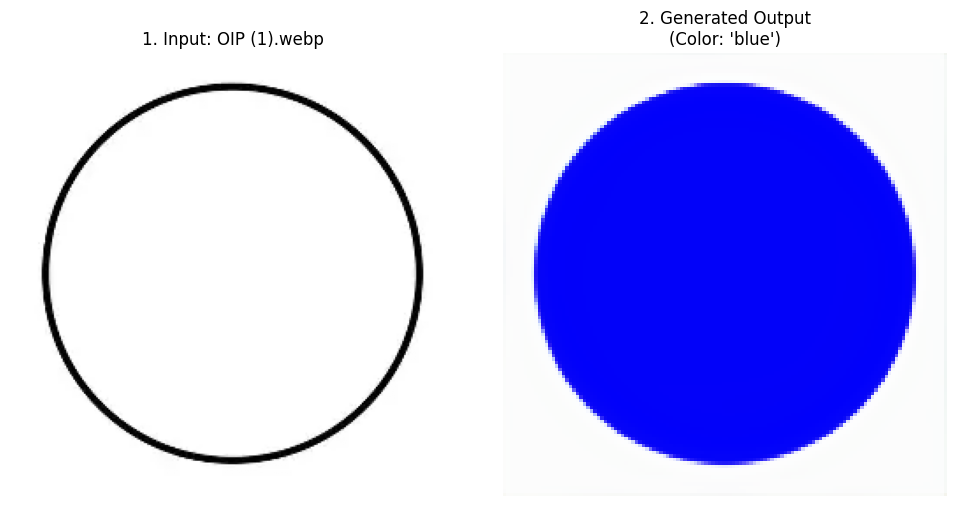

In [35]:

# ==============================================================================

shape = 'square'
color = 'blue'


# ================================================================================
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import json
import os
from sklearn.preprocessing import OneHotEncoder


from model import UNet

# --- 1. SETUP: Define constants and load necessary components ---

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# This path points to the best model saved by your final training script
MODEL_PATH = '/content/checkpoints/best_model_augmented.pth'
IMAGE_SIZE = 128 # This MUST be the same as the image_size used for training

# --- Recreate the EXACT color encoder used during training ---
# This step is mandatory to convert color names into the vectors the model understands.
json_path = 'dataset/training/data.json'
with open(json_path, 'r') as f:
    data_map = json.load(f)
# Ensure we use the correct key 'colour' from your JSON file
all_colors = sorted(list(set([item['colour'] for item in data_map])))
color_encoder = OneHotEncoder(sparse_output=False, categories=[all_colors])
color_encoder.fit(np.array(all_colors).reshape(-1, 1))
NUM_COLORS = len(all_colors)
print(f"✅ Recreated color encoder. Available colors: {all_colors}\n")


model = UNet(n_channels=1, n_classes=3, n_colors=NUM_COLORS)

# Load the saved weights from our best training epoch
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
except FileNotFoundError:
    print(f"❌ FATAL ERROR: The model file was not found at '{MODEL_PATH}'.")
    print("Please ensure you have run the training cell and the file was saved correctly.")
    # Stop execution if model not found
    assert False, "Model file not found."

model.to(DEVICE)
# Set the model to evaluation mode. This is a CRUCIAL step that disables layers
# like Dropout and uses the running averages for BatchNorm, ensuring deterministic output.
model.eval()
print(f"✅ Model loaded successfully from '{MODEL_PATH}' and set to evaluation mode.")


# --- 2. PREPARATION: Define a reusable inference function ---

def generate_colored_polygon(image_path, color_name):
    """
    Takes the path to a polygon image and a color name, and returns the generated image.
    """
    # Define the image transformations (must be identical to training)
    img_transforms = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])

    # Load and process the input image
    try:
        input_image_pil = Image.open(image_path).convert("L")
    except FileNotFoundError:
        print(f"❌ ERROR: Cannot find the image at '{image_path}'. Please check the path.")
        return None, None

    # Preprocess the inputs for the model
    input_tensor = img_transforms(input_image_pil).unsqueeze(0).to(DEVICE)
    try:
        color_vec = color_encoder.transform(np.array(color_name).reshape(-1, 1)).flatten()
    except ValueError:
        print(f"❌ ERROR: The color '{color_name}' is not recognized. Please use one of the available colors.")
        return None, None

    color_tensor = torch.tensor(color_vec, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    print(f"\n▶️ Running inference for '{os.path.basename(image_path)}' with color '{color_name}'...")

    # Run the model inside a torch.no_grad() block. This disables gradient
    # calculation, saving memory and speeding up inference.
    with torch.no_grad():
        generated_tensor = model(input_tensor, color_tensor)

    # Postprocess the generated tensor into a displayable PIL image
    generated_image_pil = transforms.ToPILImage()(generated_tensor.squeeze(0).cpu())

    print("✅ Inference complete.")
    return input_image_pil, generated_image_pil


# --- 3. EXECUTION AND VISUALIZATION ---


def get_input_path_and_color(shape: str, color: str):
    # base_path = '/content/dataset/validation/inputs/'
    # filename = f"{shape}.png"
    # input_polygon_path = base_path + filename
    input_polygon_path = "/content/OIP (1).webp"
    input_color = color
    return input_polygon_path, input_color

# Example usage

INPUT_POLYGON_PATH, INPUT_COLOR = get_input_path_and_color(shape, color)
# Generate the image using the function
input_image, generated_image = generate_colored_polygon(INPUT_POLYGON_PATH, INPUT_COLOR)

# Visualize the results only if the generation was successful
if generated_image is not None:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Input Image
    axs[0].imshow(input_image, cmap='gray')
    axs[0].set_title(f"1. Input: {os.path.basename(INPUT_POLYGON_PATH)}")
    axs[0].axis('off')

    # Generated Output
    axs[1].imshow(generated_image)
    axs[1].set_title(f"2. Generated Output\n(Color: '{INPUT_COLOR}')")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()